In [1]:
# Importing the Adult Dataset
import pandas as pd
import numpy as np

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold

In [2]:
df = pd.read_csv("adult.data", header=None)
headers = {0:"Age",1:"Workclass",2:"fnlwgt", 3:"Education", 4:"Education-num", 5:"Maritial-Status"
              , 6:"Occupation", 7:"Relationship", 8:"Race", 9:"Sex", 10:"Capital-Gain", 11:"Capital-Loss"
              , 12:"Hours-per-Week", 13:"Native-Country", 14:"Class"}
df = df.rename(columns=headers)

# Shape of Dataframe is (32561, 15)
df.head()

,Age,Workclass,fnlwgt,Education,Education-num,Maritial-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-Week,Native-Country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# One-Hot Encoding of Categorical Variables

# Drops Unecessary Columns
df = pd.get_dummies(df)
df = df.drop(['Workclass_ ?'], axis=1)
df = df.drop(['Class_ >50K'], axis=1)

df.head()

,Age,fnlwgt,Education-num,Capital-Gain,Capital-Loss,Hours-per-Week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Native-Country_ Puerto-Rico,Native-Country_ Scotland,Native-Country_ South,Native-Country_ Taiwan,Native-Country_ Thailand,Native-Country_ Trinadad&Tobago,Native-Country_ United-States,Native-Country_ Vietnam,Native-Country_ Yugoslavia,Class_ <=50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# Setting up to split 
df_array = df.as_matrix()
X = df_array[:, 0:-1] #Shape: (32561,107)
y = df_array[:, -1]   #Shape: (32561,)
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
split_per = [.2, .5, .8]
split_train = []
split_test = []
best_params = []

In [5]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [6]:
# We will use a Support Vector Classifier with "Linear" kernel

NUM_TRIALS = 3
for per in split_per:
    # Arrays to store scores
    train_score = []
    test_score = []

    # Loop for each trial
    for i in range(NUM_TRIALS):

        cv = KFold(n_splits=5, shuffle=True, random_state=i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=per)
        clf = LinearSVC()
        params = {"C": C_list}
        grid_search = GridSearchCV(clf, params, return_train_score = True, cv = cv)
        grid_search.fit(X_train, y_train)


        # Nested CV with parameter optimization
        train_score.append(grid_search.cv_results_['mean_train_score'].reshape(-1,1))
        test_score.append(grid_search.cv_results_['mean_test_score'].reshape(-1,1))

    combined_train = np.empty([len(C_list),1])
    combined_test = np.empty([len(C_list),1])

    # Averages the runs in each trial
    for i in range(len(C_list)):
        avg_train = np.empty(NUM_TRIALS)
        avg_test = np.empty(NUM_TRIALS)
        # Fill in avg_array
        for j in range(NUM_TRIALS):
            avg_train[j] = train_score[j][i]
            avg_test[j] = test_score[j][i]
        combined_train[i] = np.mean(avg_train)
        combined_test[i] = np.mean(avg_test)
    
    test_acc = sum(grid_search.best_estimator_.predict(X_test) == y_test) / len(X_test)
    best_params.append((grid_search.best_params_, test_acc))
    split_train.append(combined_train)
    split_test.append(combined_test)


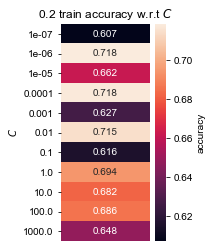

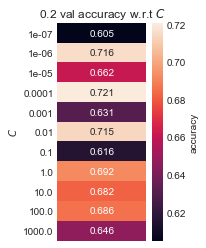

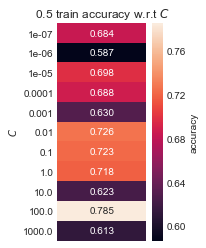

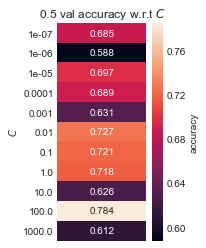

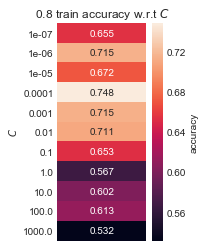

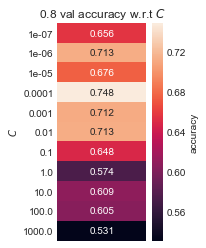

In [7]:
# Draws the heatmap of the averaged accuracies for each test-split percentage
i = 0
for per in split_per:
    draw_heatmap_linear(split_train[i], str(per) + ' train accuracy', C_list)
    draw_heatmap_linear(split_test[i], str(per) + ' val accuracy', C_list)
    i += 1

In [8]:
# 5) Use the best C and gamma to calculate the test accuracy.

test_acc = sum(grid_search.best_estimator_.predict(X_test) == y_test) / len(X_test)
print(grid_search.best_params_)
print(test_acc)

(test_acc, grid_search.best_params_)

# Use the best C and gamma to calculate the train accuracy

{'C': 100.0}
0.790049522055


(0.79004952205458945, {'C': 100.0})